# Linear Production Model

This notebook demonstrates the use of linear programming to maximize profit for a simple model of a multiproduct production facility. The notebook uses [Pyomo](http://www.pyomo.org/) to represent the model.

In [11]:
# install Pyomo and solvers for Google Colab
import sys
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()

## Learning Goals

This notebook introduces core concepts in the application of optimization techniques using a simple production planning problem. 

### Optimization

**Optimization** is the process of finding a "best" solution to a problem with multiple degrees of freedom. The components of an optimization problem are:

* **Decision Variables**: The degrees of freedom associated with a particular application. Examples might include how much of each raw material to use in a blended product, the value of a manipulated variable in feedback control, or the timing and sequencing of batch operations.

* **Constraints**: Equations or inequalities the determine the set of possible solutions to a problem. There can be many constraints in a optimization problem.

* **Objective**: A function of the decision variables that is to be either minimized or maximized. There is one optimization objective.

### Modeling for Optimization

**Modeling** for optimization is the process of creating a mathematical description of an optimization problem. 

**Algebraic Modeling Languages (AML)** are software systems for specifying and computing solutions to optimization problems. There are many examples of AML's in current use. AML are **descriptive**, not procedural. They are used to specify the problem, a numerical solution is found in a separate step using a **solver**.

**Pyomo** is a fully featured AML embedded in Python that is well suited to modeling optimization problems for process systems. This notebook demonstrates key steps in creating a Pyomo model for a simple application. 

* `import pyomo.environ as pyo` is the standard way to import pyomo into a python application. Note that Pyomo and at least one solver must be installed prior to this step.

* `model = pyo.ConcreteModel()` creates a empty model named `model`. You can choose any valid Python name. 

* `model.x = pyo.Var(domain=pyo.NonNegativeReals)` creates a new decision variable named `model.x` within the model.

* Constraints are specifed with Python functions that return logical relationships (`==`, `<=`, or `>=`) between two expressions involving the decision variables. A function is designated as a constraint with a decorator `model.Constraint()`, see examples below.

* An objective is specified with a Python function that returns an expression. An objective can be either minimized or maximized. A function is designated as an objective with the `model.Objective(sense=pyo.minimize)` or `model.Objective(sense=pyo.maximize)` decorator.

**Decorators** are a Python feature used to modify a function. Pyomo uses decorators to designate constraints, objectives, and several types of optimization objects that will be introduced in subsequent notebooks. You can think of it as a way of tagging functions with a special purpose. Decorators are implemented in Python as functions that process other functions, but those details are not needed for Pyomo modeling.

### Solving Optimization Problems

**Linear Programming**: Optimization models are categorized by their mathematical features. Solving problems with a one linear objective and multiple linear constraints is called **Linear Programming (LP)**. The problem below is a linear programming problem. 

**Solvers**: Linear programming has an enormous range of applications in business, logistics, and large scale planning problems involving up to millions of decision variables. The first practical algorithms were developed in the 1940s in the course of solving planning problems for the US Army Air Force. Since then, providing solvers for large scale linear programming has become a highly competitive commercial business. The commercial leaders are:

* **CPLEX** Founded in 1988, sold in 1997 to ILOG, later sold to IBM in 2009. This is the foundation of IBM's optimization business.

* **Gurobi**  Founded in 2008 by some of the same people involved in founding CPLEX. Generally considered the highest performing solver for large scale applications.

* **FICO Xpress**  Started in 1983 as an LP solver for PCs. Currently owned by FICO. Fast, robust, and many features beyond linear programming.

There are many, many other solvers from open-source projects, or specialized for specific applications.

### Additional Terminology

Regarding solutions:

* **Feasible Solution**: Any value of the decisions variables that satisfy all constraints.

* **Infeasible Solution**: Any value of the decisions variables that does not satisfy all constraints.

* **Optimal Solution**: A feasible solution that resulting in the smallest (minimization) or largest (maximization) value for the objective.

* **Active Constraints**: The constraints that are 'active' at the optimal solution. Tiny changes in the parameters of an active consraint will affect the solution.

* **Inactive Constraints**: Constraints that are not active at the optimal solution.  Tiny changes in the parameters of an inactive constraint will have no effect on the optimal solution.

Regarding problems:

* **Infeasible Problem**: A problem with no feasible solutions.

* **Feasible Region** The set of all feasible solutions.

* **Unbounded Problem**: A problem that admits a feasible solution with unbounded value for the objective.  





## Example: Production Plan for a Single Product Plant

Suppose you are thinking about starting up a business to produce Product X. You have determined there is a market for X of up to 40 units per week at a price of \$270 each. The production of each unit requires \$100 of raw materials, 1 hour of type A labor, and 2 hours of type B labor. You have an unlimited amount of raw material available to you, but only 80 hours per week of labor A at a cost of \$50/hour, and 100 hours per week of labor B at a cost of \$40 per hour. Ignoring all other expenses, what is the maximum weekly profit?

To get started on this problem, we sketch a flow diagram illustrating the flow of raw materials and labor through the production plant.


![LP_ProductX.png](../figures/LP_ProductX.png)

The essential decision we need to make is how many units or Product X to produce each week. That's our *decision variable* which we denote as $x$. The weekly revenues are then

$$ \text{Revenue} = \$270 x $$

The costs include the value of the raw materials and each form of labor. If we produce x units a week, then the total cost is

$$ \text{Cost} = \underbrace{\$100 x}_{\text{Raw Material}} 
    + \underbrace{\$50 x}_{\text{Labor A}} + \underbrace{2\times\$40 x}_{\text{Labor B}} = \$230 x$$
    
We see immediately that the gross profit is just

$$\begin{align*}\text{Profit} & = & \text{Revenue} - \text{Cost} \\
& = & \$270x - \$230x \\
& = & \$40 x
\end{align*}$$

which means there is a profit earned on each unit of X produced, so let's produce as many as possible. 

There are three constraints that limit how many units can be produced. There is market demand for no more than 40 units per week. Producing $x = 40$ units per week will require 40 hours per week of Labor A, and 80 hours per week of Labor B. Checking those constraints we see that we have enough labor of each type, so the maximum profit will be

$$\max \text{Profit} = \$40 \text{ per unit} \times 40 \text{ units per week} = \$1600 \text{ per week}$$

What we conclude is that market demand is the 'most constraining constraint.' Once we've made that deduction, the rest is a straightforward problem that can be solved by inspection.  

### Mathematical Model

Even though this example has a straightforward solution, it is useful to consider how it can be represented mathematically, and solved using typical tools for linear programming.

The mathematical representation consists of a single non-negative decision variable, $x$, an objective function, and a set of linear constraints.  Here we include all constraints even though we know only one of them -- the most 'constraining constraint' -- will be active.

$$\begin{align}
\max_{x \geq 0} &\ 40\ x  & \text{objective}\\
\text{subject to:}\qquad \\
x & \leq 40  & \text{demand constraint} \\
x & \leq 80  & \text{labor A constraint} \\
2\ x & \leq 100 & \text{labor B constraint}
\end{align}$$

All of these constraints must be satisfied, therefore the demand constraint is the 'most constrainting'. Again, the maximum value of $x$ is 40, so the maximum profit is $\$ 40 \times 40 = \$1,600$.

### Exercises

1. Suppose the demand could be increased to 50 units per month. What would be the increased profits?  What if the demand increased to 60 units per month?  How much would you be willing to pay for your marketing department for the increased demand?

2. Increase the cost of LaborB. At what point is it no longer financially viable to run the plant?

## Production Plan: Product Y

Your marketing department has developed plans for a new product called Y. The product sells at a price of \$210 each, and they expect that you can sell all that you can make. It's also cheaper to make, requiring only \$90 in raw materials, 1 hour of Labor type A at \$50 per hour, and 1 hour of Labor B at \$40 per hour. What is the potential weekly profit?

![LP_ProductY.png](../figures/LP_ProductY.png)

The analysis proceeds in the same form as Product X. In this case the revenue is given by

$$ \text{Revenue} = \$210 y $$

The total cost is

$$ \text{Cost} = \underbrace{\$90 x}_{\text{Raw Material}} 
    + \underbrace{\$50 x}_{\text{Labor A}} + \underbrace{\$40 x}_{\text{Labor B}} = \$180 x$$
    
The gross profit is thus

$$\begin{align*}\text{Profit} & = & \text{Revenue} - \text{Cost} \\
& = & \$210y - \$180y \\
& = & \$30 y
\end{align*}$$

We see the profit per unit of Y is smaller. So a decision to produce Y instead of X must be based on the ability to make Y in larger quantities.

The mathematical formulation of this problem becomes

$$\begin{align*}
\max_{y \geq 0} &\ 30\ y  & \text{objective}\\
\text{subject to:}\qquad \\
y & \leq 80  & \text{labor A constraint} \\
y & \leq 100 & \text{labor B constraint}
\end{align*}$$

Compared to product X, we can manufacture and sell up 80 units per week for a total profit of \$2,400. This is very welcome news. 

### Exercises

1. What is the limiting resource?  That is, which of the two types of labor limits the capacity of your plant to produce more units of Y?

2. What rate would you be willing to pay for the additional labor necessary to increase the production of Y?

## Production Plan: Mixed Product Strategy

So far we have learned that we can make \$1,600 per week by manufacturing product X, and \$2,400 per week manufacturing product Y.  Is it possible to do even better?

To answer this question, we consider the possibilty of manufacturing both products in the same plant. The marketing department assures us that product Y will not affect the sales of product X.  So the same constraints hold as before, but now we have two decision variables, $x$ and $y$.

![LP_ProductXY.png](../figures/LP_ProductXY.png)

Mathematical formulation

$$\begin{align}
\max_{x,y \geq 0} &\ 40\ x + 30\ y  & \text{objective}\\
\text{subject to:}\qquad \\
x & \leq 40  & \text{demand constraint} \\
x + y & \leq 80  & \text{labor A constraint} \\
2x + y & \leq 100 & \text{labor B constraint}
\end{align}$$

## Solution using Pyomo

In [4]:
import pyomo.environ as pyo

# create a new model
model = pyo.ConcreteModel("Production Model")

# add decision variables x and y
model.x = pyo.Var(domain=pyo.NonNegativeReals)
model.y = pyo.Var(domain=pyo.NonNegativeReals)

# add objective
@model.Objective(sense=pyo.maximize)
def profit(model):
    return 40*model.x + 30*model.y

# add constraints
@model.Constraint()
def demand(model):
    return model.x <= 40

@model.Constraint()
def laborA(model):
    return model.x + model.y <= 80

@model.Constraint()
def laborB(model):
    return 2*model.x + model.y <= 100

# compute solution
# solver = pyo.SolverFactory('gurobi_direct')
solver = pyo.SolverFactory('cbc')
solver.solve(model)

# display solution
print("profit = ", model.profit())
print("x = ", model.x())
print("y = ", model.y())

profit =  2600.0
x =  20.0
y =  60.0


The mixed product strategy earns more profit than either of the single product srategies. Does this surprise you?  Before going further, try to explain why it is possible for a mixed product strategy to earn more profit than either of the possible single product strategies.

## What are the active constraints?

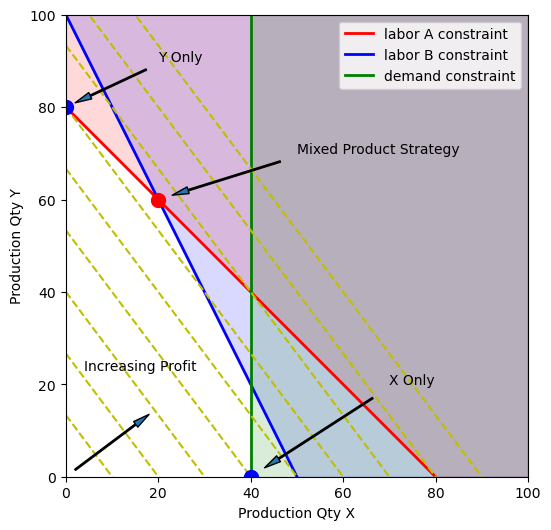

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.set_aspect('equal')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('Production Qty X')
ax.set_ylabel('Production Qty Y')

# labor A constraint
x = np.array([0, 80])
y = 80 - x
ax.plot(x, y , 'r', lw=2, label="labor A constraint")
ax.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)

# labor B constraint
x = np.array([0, 50])
y = 100 - 2*x
ax.plot(x, y, 'b', lw=2, label="labor B constraint")
ax.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# demand constraint
ax.plot([40, 40], [0, 100], 'g', lw=2, label="demand constraint")
ax.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

ax.legend()

# Contours of constant profit
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    ax.plot(x, y, 'y--')

# annotations
arrowprops = {"shrink": 0.1, "width": 1, "headwidth": 5}

ax.plot(20, 60, 'r.', ms=20)
ax.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), arrowprops=arrowprops)

ax.plot(0, 80, 'b.', ms=20)
ax.annotate('Y Only', xy=(0,80), xytext=(20,90), arrowprops=arrowprops)

ax.plot(40,0,'b.',ms=20)
ax.annotate('X Only', xy=(40,0), xytext=(70,20), arrowprops=arrowprops)

ax.text(4,23,'Increasing Profit')
ax.annotate('', xy=(20,15), xytext=(0,0), arrowprops=arrowprops)

if not on_colab:
    # Only save the figure if not running in Google Colab
    plt.savefig('../figures/LPprob01.png', bbox_inches='tight')

## What is the incremental value of labor?

The optimal solution is found at the intersection of constraints corresponding to Labor A and Labor B.  These are the **active constraints**. Adding additional labor of either type will increase the profit.  By contrast, the demand constraint for product X is inactive at the optimum, therefore attempting to increase demand for product X would be wasted effort.

This leaves the important question of how much the profit will increase if additional resources are available. Let's see what happens if one additional hour of Labor A is available.

For this analysis, we repackage the Pyomo model into a Python function that accepts values for the available resources (i.e, demand, labor A, and labor B). This packaging makes it easy to do sensitivity studies, like this one, where parameters in the problem are adjusted to determine their impact on the optimal response.

In [10]:
import pyomo.environ as pyo

def production_model(demand=40, laborA=80, laborB=100):
    ''' Production model with demand, laborA, and laborB constraints

    Arguments:
        demand: float, maximum demand for product X
        laborA: float, maximum availability of labor A
        laborB: float, maximum availability of labor B
    
    Returns:
        model: solved Pyomo model object 
    '''

    # create a new model
    model = pyo.ConcreteModel("Production Model")

    # add decision variables x and y
    model.x = pyo.Var(domain=pyo.NonNegativeReals)
    model.y = pyo.Var(domain=pyo.NonNegativeReals)

    # add objective
    @model.Objective(sense=pyo.maximize)
    def profit(model):
        return 40*model.x + 30*model.y

    # add constraints
    @model.Constraint()
    def demand(model):
        return model.x <= demand

    @model.Constraint()
    def laborA(model):
        return model.x + model.y <= laborA

    @model.Constraint()
    def laborB(model):
        return 2*model.x + model.y <= laborB

    # compute solution
    # solver = pyo.SolverFactory('gurobi_direct')
    solver = pyo.SolverFactory('cbc')
    solver.solve(model)
    
    return model

# Build and solve the optimization problem
model= production_model(40, 81, 100)

# Extract and print the solution
print("profit = ", model.profit())
print("x = ", model.x())
print("y = ", model.y())

profit =  2620.0
x =  19.0
y =  62.0


An additional hour of Labor A increases the profit by 20 dollars. The base cost of 50 dollars per hour for Labor A is included in the objective function. Therefore we should be willing to pay up to 50 + 20 = 70 dollars per hour for additional Labor A.

### Exercise

1. What is the incremental value of Labor B?

## Theory of Constraints

* For $n$ decisions you should expect to find $n$ 'active' constraints.
* Each inactive constraint has an associated 'slack.'  The associated resources have no incremental value.
* Each active constraint has an associated 'shadow price'.  This is additional value of additional resources.